In [56]:
import os
from os import path as ospath
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from spiketools.plts.spikes import plot_firing_rates
from convnwb.io import open_h5file, get_files, load_config, save_json, load_json,make_session_name,load_nwbfile
from convnwb.paths import Paths

from spiketools.measures.spikes import compute_firing_rate
from spiketools.plts.data import plot_bar, plot_hist, plot_text, plot_barh
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.spatial.utils import compute_pos_ranges, compute_bin_width
from spiketools.utils.trials import recombine_trial_data
from spiketools.utils.epoch import epoch_data_by_range
from spiketools.plts.spatial import plot_position_by_time,plot_heatmap,create_heatmap_title
from spiketools.utils.timestamps import convert_sec_to_min, sum_time_ranges
from spiketools.spatial.occupancy import compute_occupancy,compute_trial_occupancy, compute_bin_edges,compute_bin_counts_pos, normalize_bin_counts
from spiketools.utils.extract import get_range, get_values_by_time_range, get_values_by_times,get_inds_by_times
from spiketools.plts.utils import make_grid, get_grid_subplot
from spiketools.stats.shuffle import shuffle_circular,shuffle_bins
from spiketools.plts.spatial import plot_positions, plot_heatmap
from spiketools.spatial.speed import compute_speed
from spiketools.plts.data import plot_hist, plot_bar, plot_lines
from spiketools.plts.annotate import add_vlines, add_hlines
from spiketools.plts.data import plot_polar_hist
from spiketools.utils.epoch import epoch_spikes_by_range
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.spikes import plot_waveform
from spiketools.stats.shuffle import shuffle_bins,shuffle_isis
from spiketools.plts.trials import plot_rasters
from spiketools.utils.extract import (get_range, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_values,get_value_range)
from spiketools.plts.style import drop_spines
from spiketools.plts.stats import plot_surrogates

In [57]:
import sys
sys.path.append('../code')
from plts import plot_task_structure,plot_positions_with_speed
from utils import group_array_by_key
from reports import create_sess_str
from group import get_all_session_paths
from models import create_df_place,fit_anova_place
from trial import get_trial_structure

sys.path.append('../scripts')
from settings import RUN, PATHS, UNITS,METHODS, SURROGATES


# Settings 

In [58]:
PATHS['DATA']

PosixPath('/Users/weijiazhang/Data/Train/nwb')

In [59]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1139C',
    'session' : '0'    
}

In [60]:
experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1139C_session_0'

# Load Data 

In [61]:
# Load NWB file
nwbfile = load_nwbfile(session_name+'.nwb', PATHS['DATA'])

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/pynwb/base.py:195: UserWarning: Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.
  warn('Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.')


In [62]:
nwbfile

root pynwb.file.NWBFile at 0x4961919248
Fields:
  acquisition: {
    boundaries <class 'pynwb.behavior.Position'>,
    position <class 'pynwb.behavior.Position'>
  }
  data_collection: unknown
  devices: {
    Microwire Electrodes <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    BF electrode <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: The Train task is a spatial memory navigation task.  Subjects navigate across a linear track, learning and reporting objects which are presented at specific spatial positions. (Task: Train build-main (Unity-english)).
  experimenter: ['Qasim, Salman' 'Jacobs, Joshua']
  file_create_date: [datetime.datetime(2024, 3, 25, 17, 11, 18, 212664, tzinfo=tzoffset(None, -14400))]
  identifier: TRAIN_R1139C_session_0
  institution: Columbia University
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <StrDataset for HDF5 dataset "keywords": shape (3,), type "|O">
  lab: Electrophysiology, Memory, and Navigation Laboratory
  notes: The exact subtracted timestamp is: 779.2026325683594
  processing: {
    position_measures <class 'pynwb.base.ProcessingModule'>
  }
  session_description: This file contains a recorded session of the Train task, a spatial-navigation memory task, from a human neurosurgical patient with microwires that record single-unit activity.
  session_id: TRAIN_R1139C_session_0
  session_start_time: 1969-12-31 19:00:00.779203-05:00
  source_script: https://github.com/HSUPipeline/ConvertTrain/
  source_script_file_name: scripts//home1/tom.donoghue/conversions/ConvertTrain/scripts/convert_data.py
  stimulus: {
    objects <class 'pynwb.base.TimeSeries'>,
    positions <class 'pynwb.base.TimeSeries'>
  }
  stimulus_notes: The stimuli are object that are presented along a linear track.
  subject: subject pynwb.file.Subject at 0x4960754640
Fields:
  description: The subject is a clinical patient with intractable epilepsy undergoing pre-surgical mapping in an epilepsy monitoring unit, with implanted electrodes including microwires that can detect single-unit activity.
  species: Homo sapiens
  subject_id: R1139C

  timestamps_reference_time: 1969-12-31 19:00:00.779203-05:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'>
  units: units <class 'pynwb.misc.Units'>

In [63]:
# Get unit data 
n_units = len(nwbfile.units)
print('Number of unit: {}'.format(n_units))
session['n_units'] = n_units

Number of unit: 15


In [64]:
# Get spiking activity from across all units
all_spikes = [nwbfile.units.get_unit_spike_times(uind) for uind in range(n_units)]

In [65]:
# Calculate the average overall firing rate of each neuron
rates = [compute_firing_rate(spikes) for spikes in all_spikes]

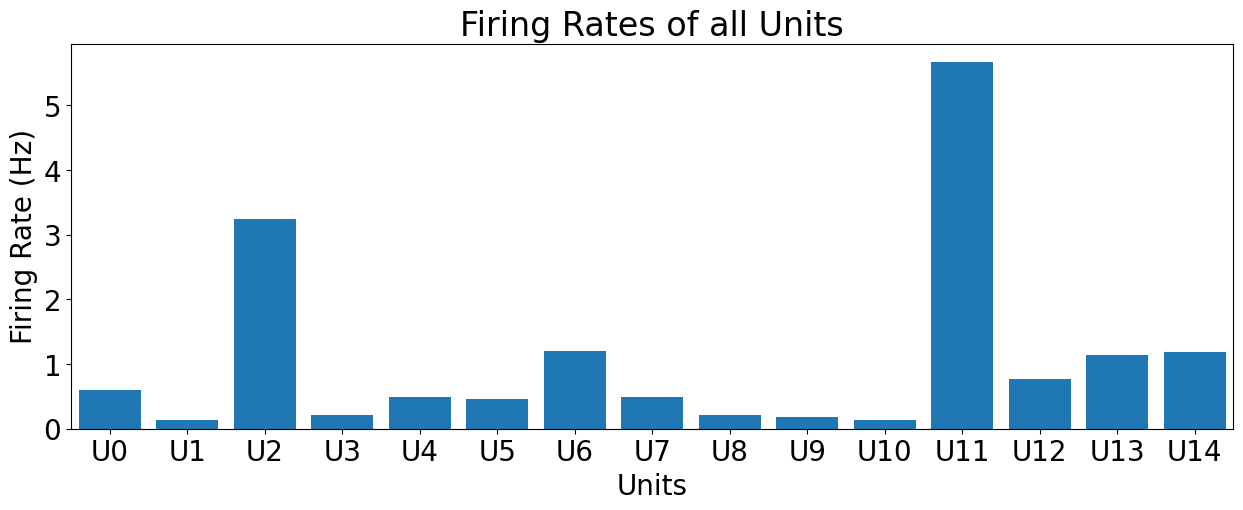

In [66]:
# Plot approximate firing rate for each unit
plot_firing_rates(rates, figsize=(15, 5))

## Get position data 

In [67]:
# Grab the position data
pos = nwbfile.acquisition['position']['player_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

In [68]:
print("ptimes:", ptimes.shape)
print("positions:", positions.shape)

ptimes: (7240,)
positions: (7240,)


In [69]:
# Compute position ranges
x_min_track, x_max_track = compute_pos_ranges(positions)
track_range = [x_min_track,x_max_track]
track_length = x_max_track-x_min_track

print('Track Range: ', track_range)
print('Track Length: ', track_length)

Track Range:  [-33.9996, 34.826]
Track Length:  68.82560000000001


In [70]:
# Binning 
num_bins =40
bins = np.linspace(x_min_track, x_max_track, num_bins+1)
bin_edges = compute_bin_edges(positions, num_bins)
bin_width = compute_bin_width(bin_edges)
print('Number of bins: ', num_bins)
print('Bin widths: {:1.2f}'.format(bin_width))

Number of bins:  40
Bin widths: 1.72


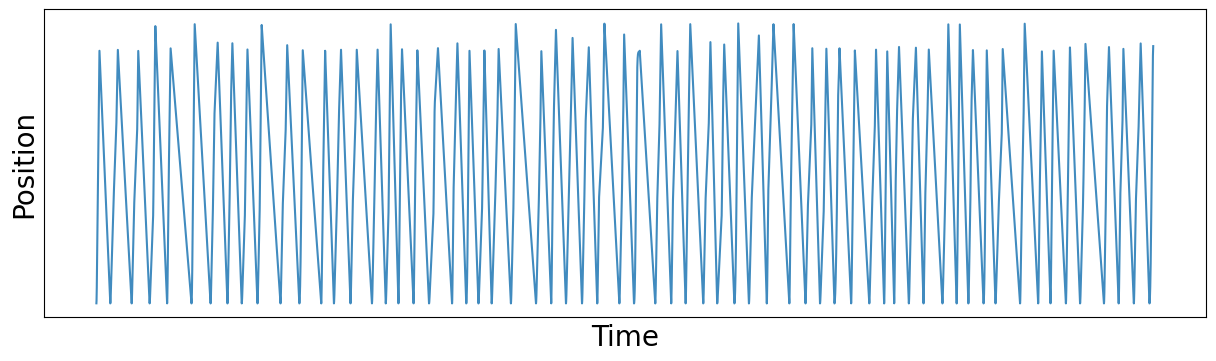

In [71]:
# Plot position across time
plot_position_by_time(ptimes, positions, alpha=0.85, figsize=(15, 4))

## Get speed data 

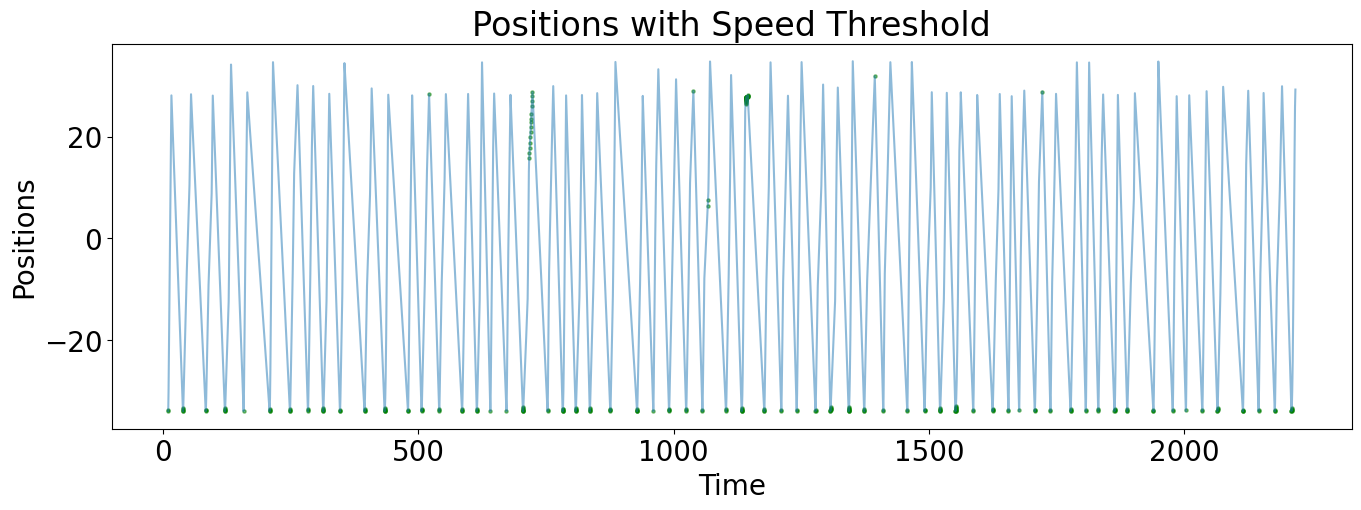

In [72]:
speed_thresh =2
speed = compute_speed(positions, ptimes)
plot_positions_with_speed(ptimes, positions, speed,speed_thresh)

## Get trial data 

In [73]:
move_start = nwbfile.trials['movement_start_time']
move_end = nwbfile.trials['movement_stop_time']

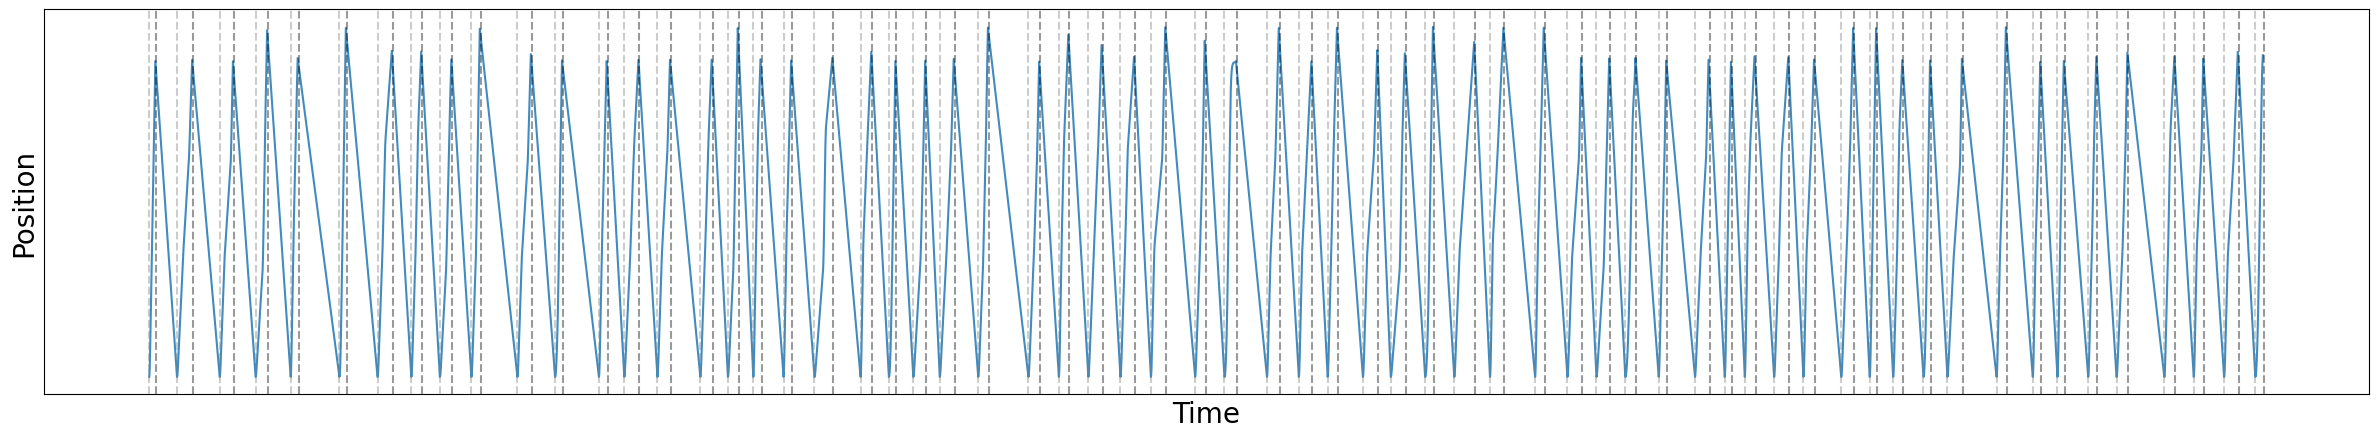

In [74]:
plot_position_by_time(ptimes, positions, alpha=0.85,figsize=(30, 5))
for start in move_start:
    plt.axvline(x=start, color='grey', alpha=0.4, linestyle='--', label='Trial Start' if start == move_start[0] else "")
for end in move_end:
    plt.axvline(x=end, color='black', alpha=0.4, linestyle='--', label='Trial End' if end == move_end[0] else "")

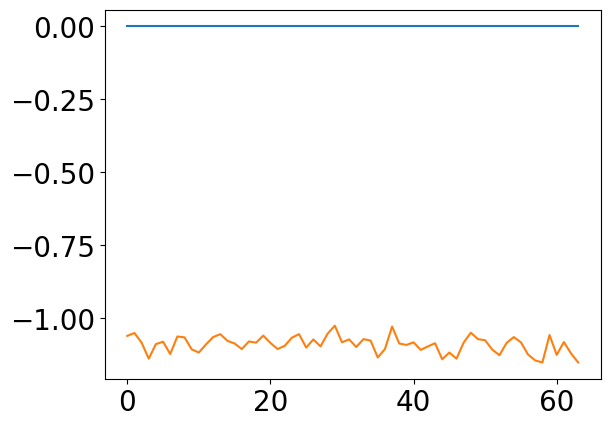

In [75]:
## trial structure check
trial_start,trial_end = get_trial_structure(ptimes, positions,mini=-25,maxi = 25, dist = 100)
# Plot the difference between movement start and trial start 
min_trials_len = np.min([len(move_start),len(trial_start)])
plt.plot(trial_start[:min_trials_len]-move_start[:min_trials_len])
plt.plot(trial_end[:min_trials_len]-move_end[:min_trials_len])

# Occupancy 

Track range: [-32.27896, 27.94343999999999]
Number of bins: 35


/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/spiketools/utils/checks.py:288: UserWarning: The data values extend beyond the given bin definition.
  warnings.warn(msg)


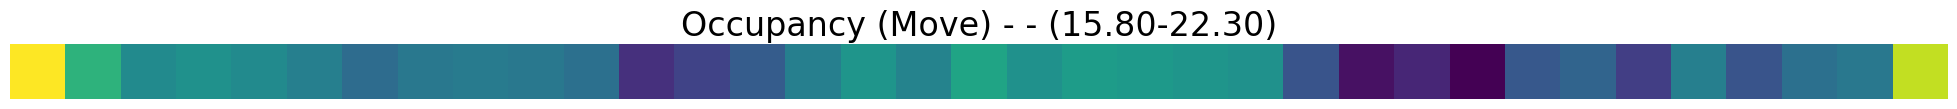

In [76]:
stoping_zone = 4
starting_zone= 1

x_min = x_min_track+starting_zone*bin_width
x_max = x_max_track-stoping_zone*bin_width

track_range = [x_min,x_max]
print('Track range:', track_range)


move_bins = num_bins-stoping_zone-starting_zone
print('Number of bins:' , move_bins)
move_occ = compute_occupancy(positions, ptimes, move_bins,min_speed=speed_thresh,area_range = track_range)
plot_heatmap(move_occ, title=create_heatmap_title('Occupancy (Move) -',move_occ), figsize=(25, 5))

m_bins = np.linspace(x_min, x_max, move_bins+1)

## Filtered Positions 

In [77]:
filt_ptimes,filt_positions = get_value_range(ptimes,positions, min_value = x_min, max_value = x_max)

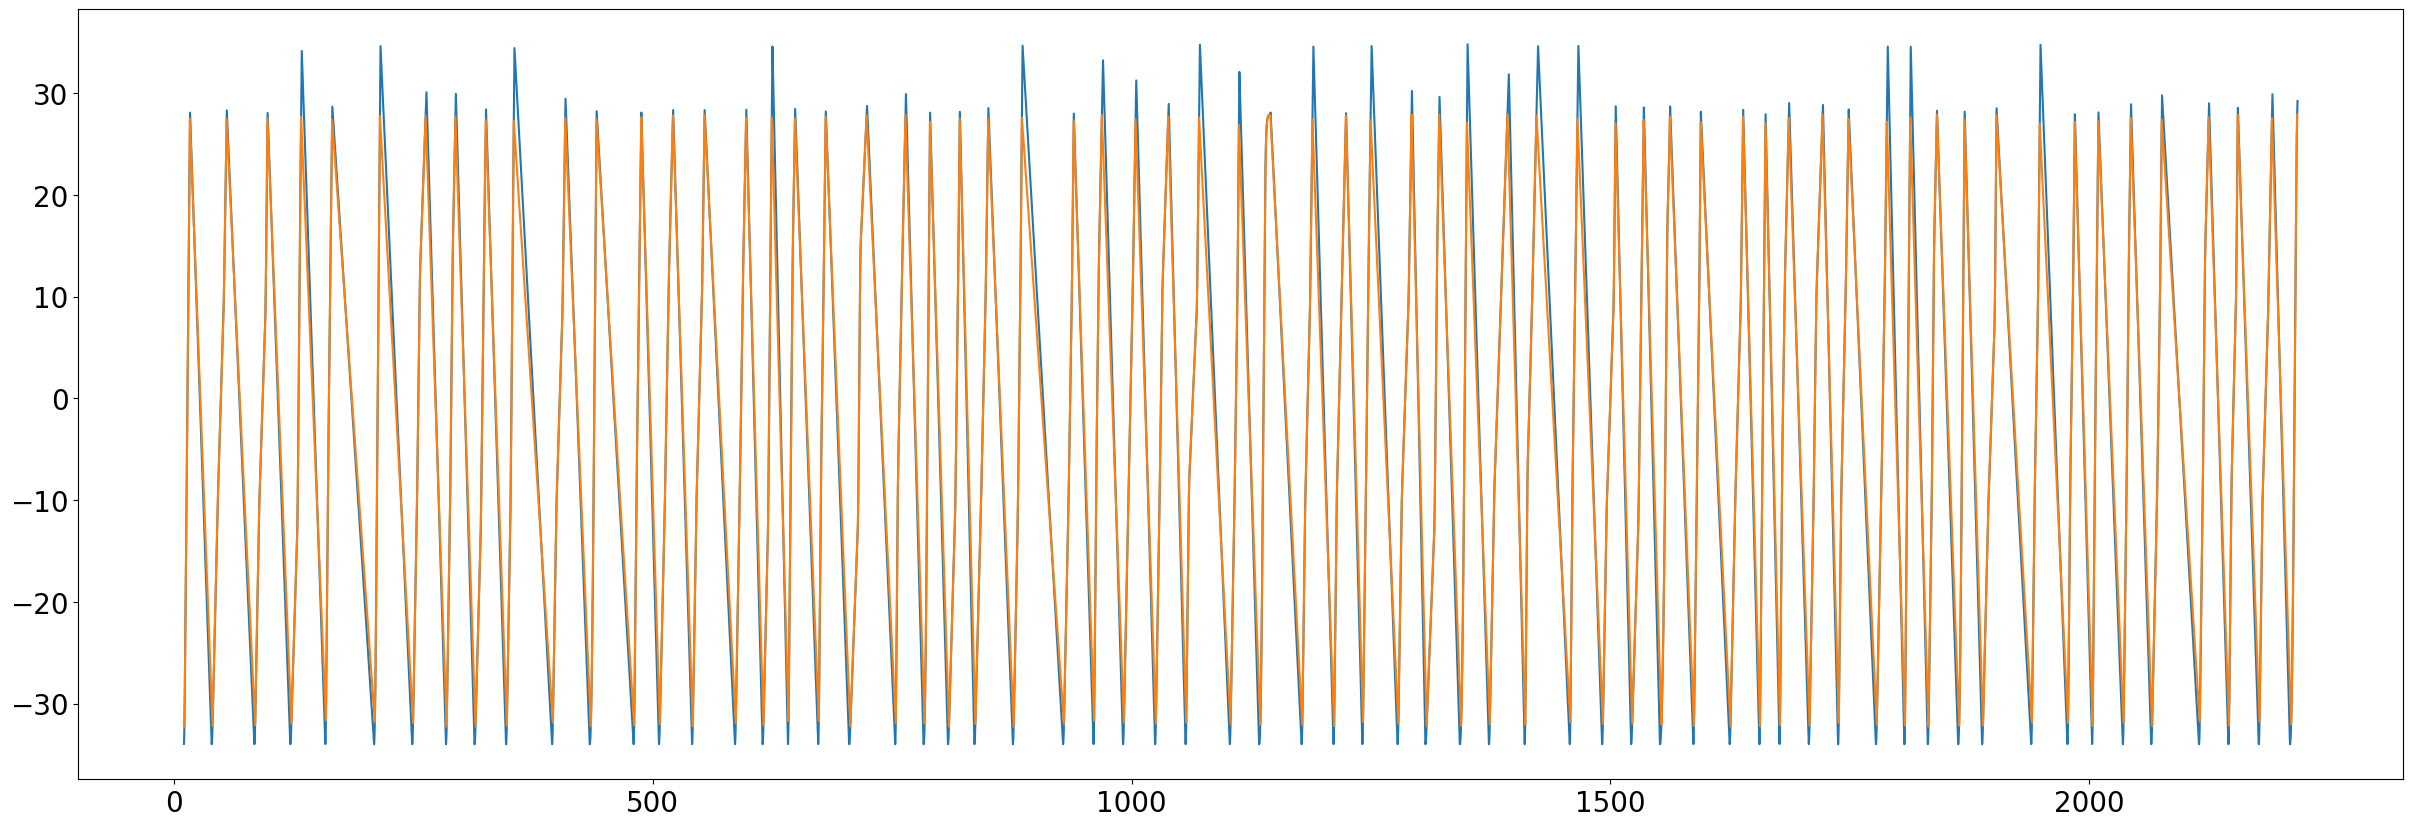

In [78]:
plt.figure(figsize = (30,10))
plt.plot(ptimes, positions)
plt.plot(filt_ptimes, filt_positions)

## Trial Occupancy 

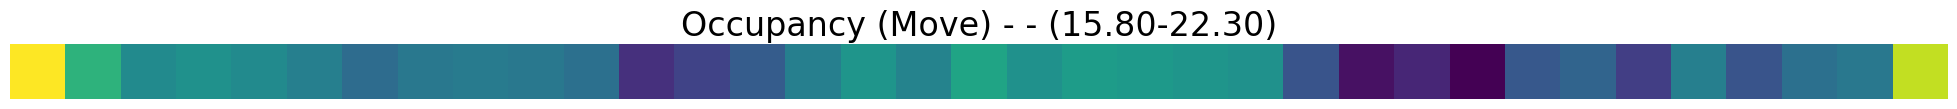

In [79]:
trial_occupancy = compute_trial_occupancy(positions, ptimes, move_bins, move_start, move_end,area_range = track_range)
occ_t = np.sum(trial_occupancy, axis=0)

plot_heatmap(occ_t, title=create_heatmap_title('Occupancy (Move) -',occ_t), figsize=(25, 5))

# Single Unit 

In [80]:
# Extract spikes for a unit of interest
uind = 0
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes_p = get_values_by_times(ptimes, positions,spikes,time_threshold = 0)
spikes_t = get_values_by_times(ptimes, ptimes,spikes,time_threshold = 0)
print(spikes.shape)

(1842,)


Text(0.5, 1.0, 'Unit 0')

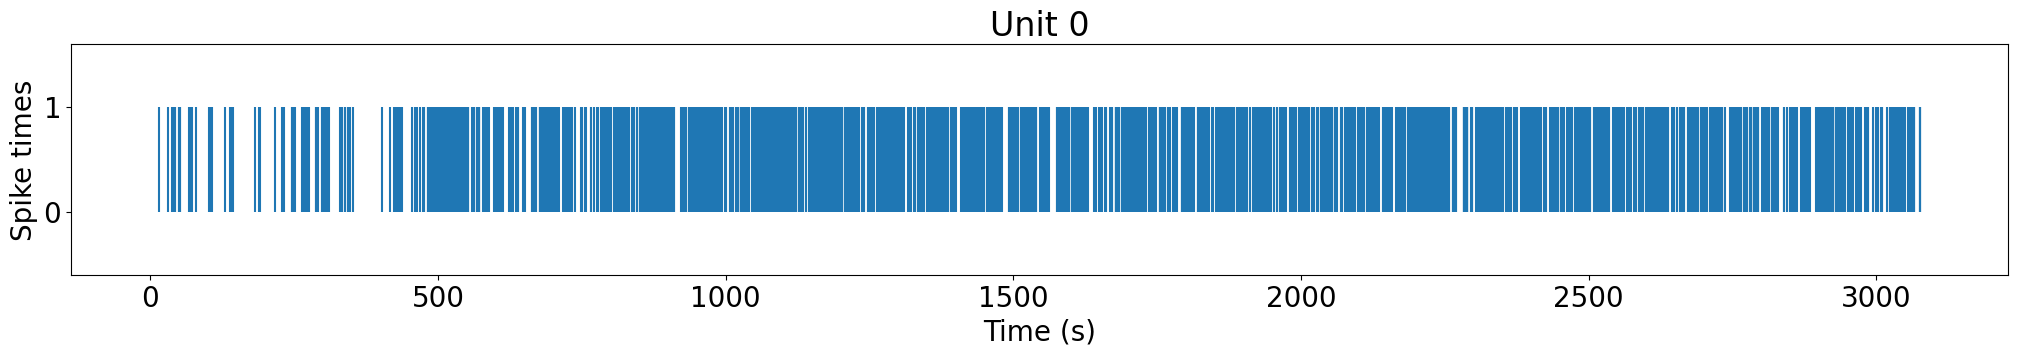

In [81]:
plt.figure(figsize=(25, 3))
plt.eventplot(spikes, lineoffsets=0.5, colors=f'C{uind}')
plt.xlabel('Time (s)')
plt.ylabel('Spike times')
plt.title(f'Unit {uind}')

Text(0.5, 1.0, ' Unit 0: Spike Position by Time')

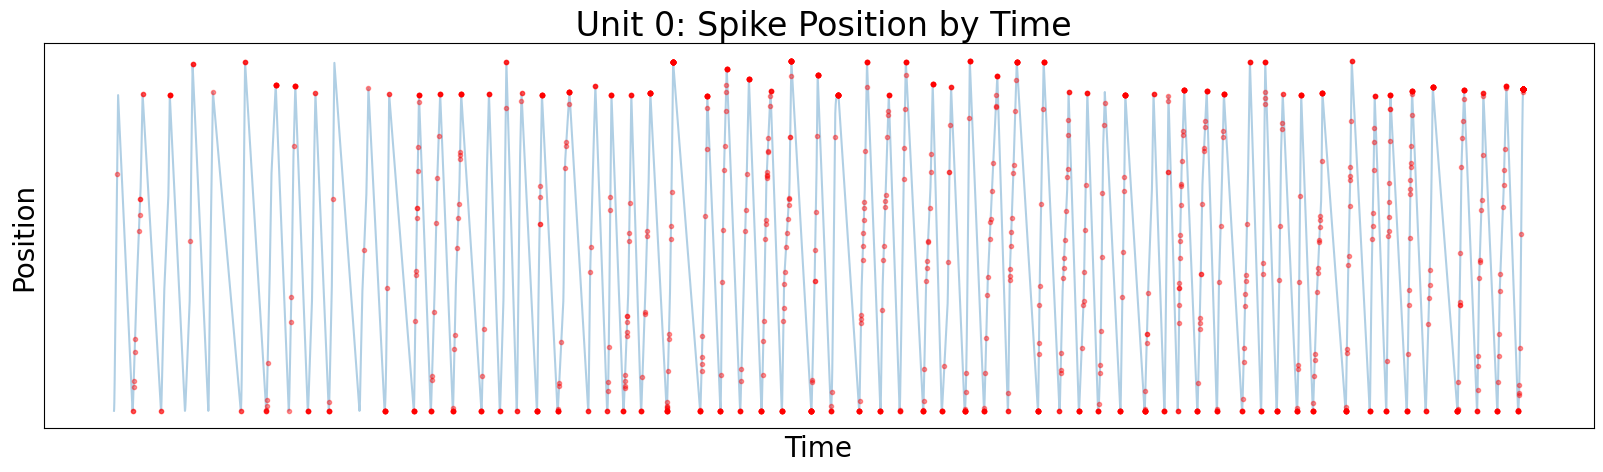

In [82]:
plot_position_by_time(ptimes,positions,spikes_t,spikes_p,figsize =(20,5))
plt.title(f' Unit {uind}: Spike Position by Time')

## Spikes During Movement Period 

In [83]:
# Get spikes during movement period 
spike_trials = epoch_spikes_by_range(spikes, move_start, move_end, reset=False)
trial_spikes_all = np.concatenate(spike_trials).ravel()

Text(0.5, 1.0, 'Unit 0')

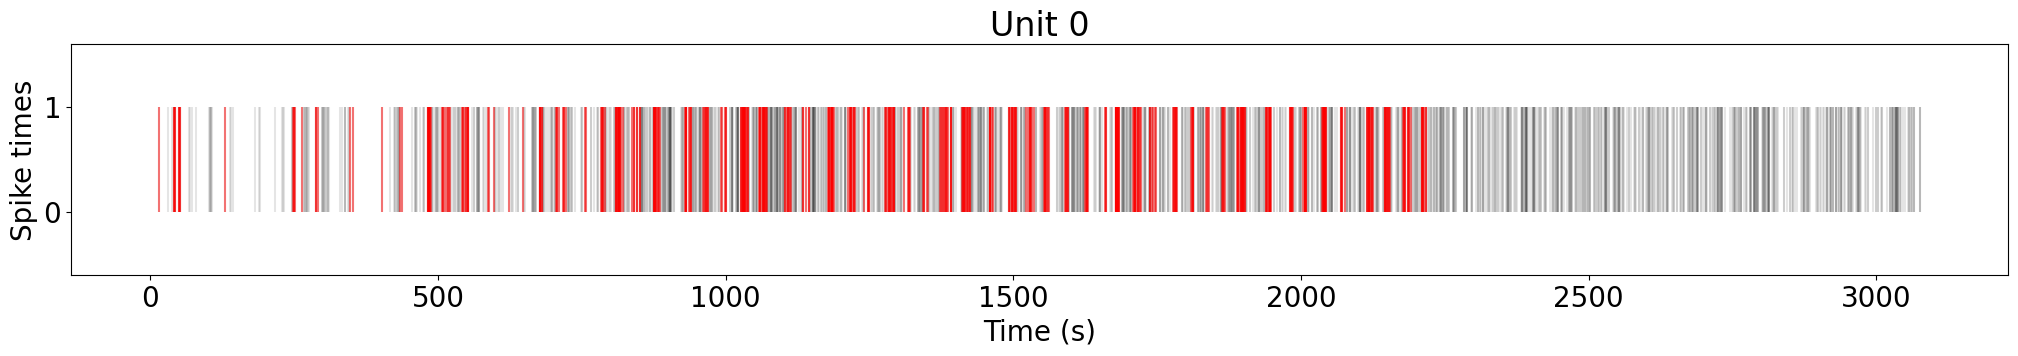

In [84]:
plt.figure(figsize=(25, 3))
plt.eventplot(spikes, lineoffsets=0.5,color = 'black', alpha = .1)
plt.eventplot(trial_spikes_all, lineoffsets=0.5,color = 'red',alpha = .5)
plt.xlabel('Time (s)')
plt.ylabel('Spike times')
plt.title(f'Unit {uind}')

In [85]:
spike_pos = []
spike_t = []
for ind in range(len(spike_trials)): 
    t_spikes = spike_trials[ind]
    spike_pos.append(get_values_by_times(filt_ptimes, filt_positions, t_spikes,time_threshold = .1))
    spike_t.append(get_values_by_times(filt_ptimes, filt_ptimes, t_spikes,time_threshold = .1))
spike_pos_all = np.concatenate(spike_pos).ravel()
spike_t_all = np.concatenate(spike_t).ravel()

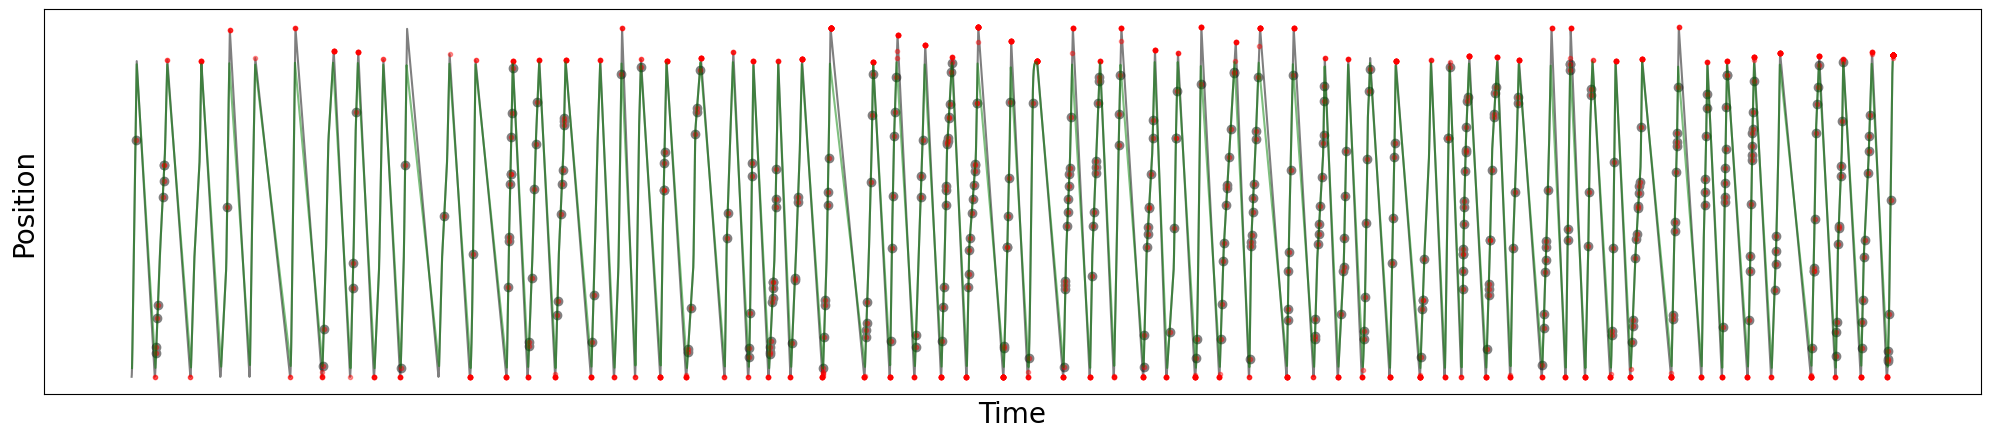

In [86]:
plot_position_by_time(ptimes,positions,spikes_t,spikes_p,figsize =(25,5),color = 'black',alpha = .5)
plt.plot(filt_ptimes, filt_positions,alpha = .5,color = 'green')
plt.scatter(spike_t_all,spike_pos_all, color = 'grey')

## Trial Firing Rate 

In [87]:
trial_place_bins = compute_trial_place_bins(spikes, positions, ptimes,move_bins, trial_start, trial_end,time_threshold = .1,
trial_occupancy=trial_occupancy, area_range = track_range,flatten=True)

In [88]:
fr = np.mean(trial_place_bins, axis=0)
fr_std = np.std(trial_place_bins, axis=0)

# Statistic 

In [89]:
spike_info = compute_spatial_information(fr, occ_t)
print("Spatial Information: ",np.round(spike_info,3))

Spatial Information:  0.096


In [90]:
df = create_df_place(trial_place_bins)
f_val = fit_anova_place(df)

print('F Statistics: ', np.round(f_val,3))

F Statistics:  1.162


# Shuffle 

In [91]:
shuffles = shuffle_spikes(spikes, SURROGATES['approach'],SURROGATES['n_shuffles'])

p-value: 0.52
z-score: 0.10
p-value: 0.24
z-score: 0.51


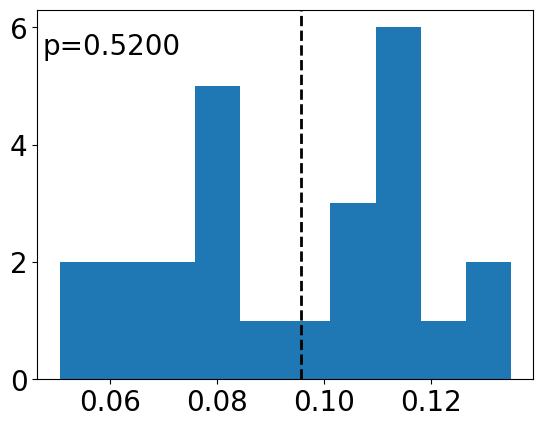

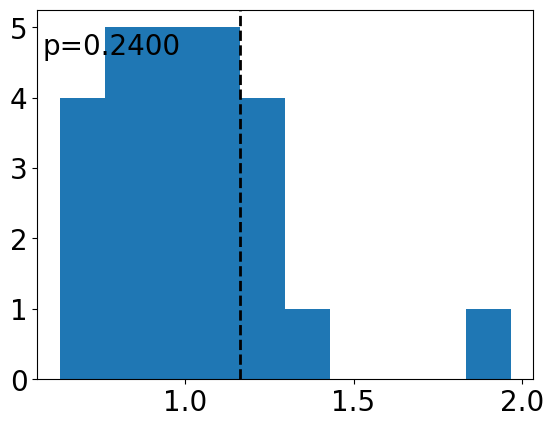

In [96]:
surrs = np.zeros(SURROGATES['n_shuffles'])
surrogates = np.zeros(SURROGATES['n_shuffles'])
for ind, stimes in enumerate(shuffles):
    trial_place_bins = compute_trial_place_bins(stimes, positions, ptimes,move_bins, move_start, move_end,time_threshold = .1,
trial_occupancy=trial_occupancy, area_range = track_range,flatten=True)
    bin_firing = np.mean(trial_place_bins, axis=0)
    surrs[ind] = compute_spatial_information(bin_firing, occ_t, normalize=True)
    surrogates[ind] = fit_anova_place(create_df_place(trial_place_bins)) 
si_p_val,si_z_score = compute_surrogate_stats(spike_info, surrs, verbose=True,plot = True)   
f_p_val, f_z_score = compute_surrogate_stats(f_val, surrogates, verbose=True,plot = True)

Text(0.5, 1.0, 'Unit 0')

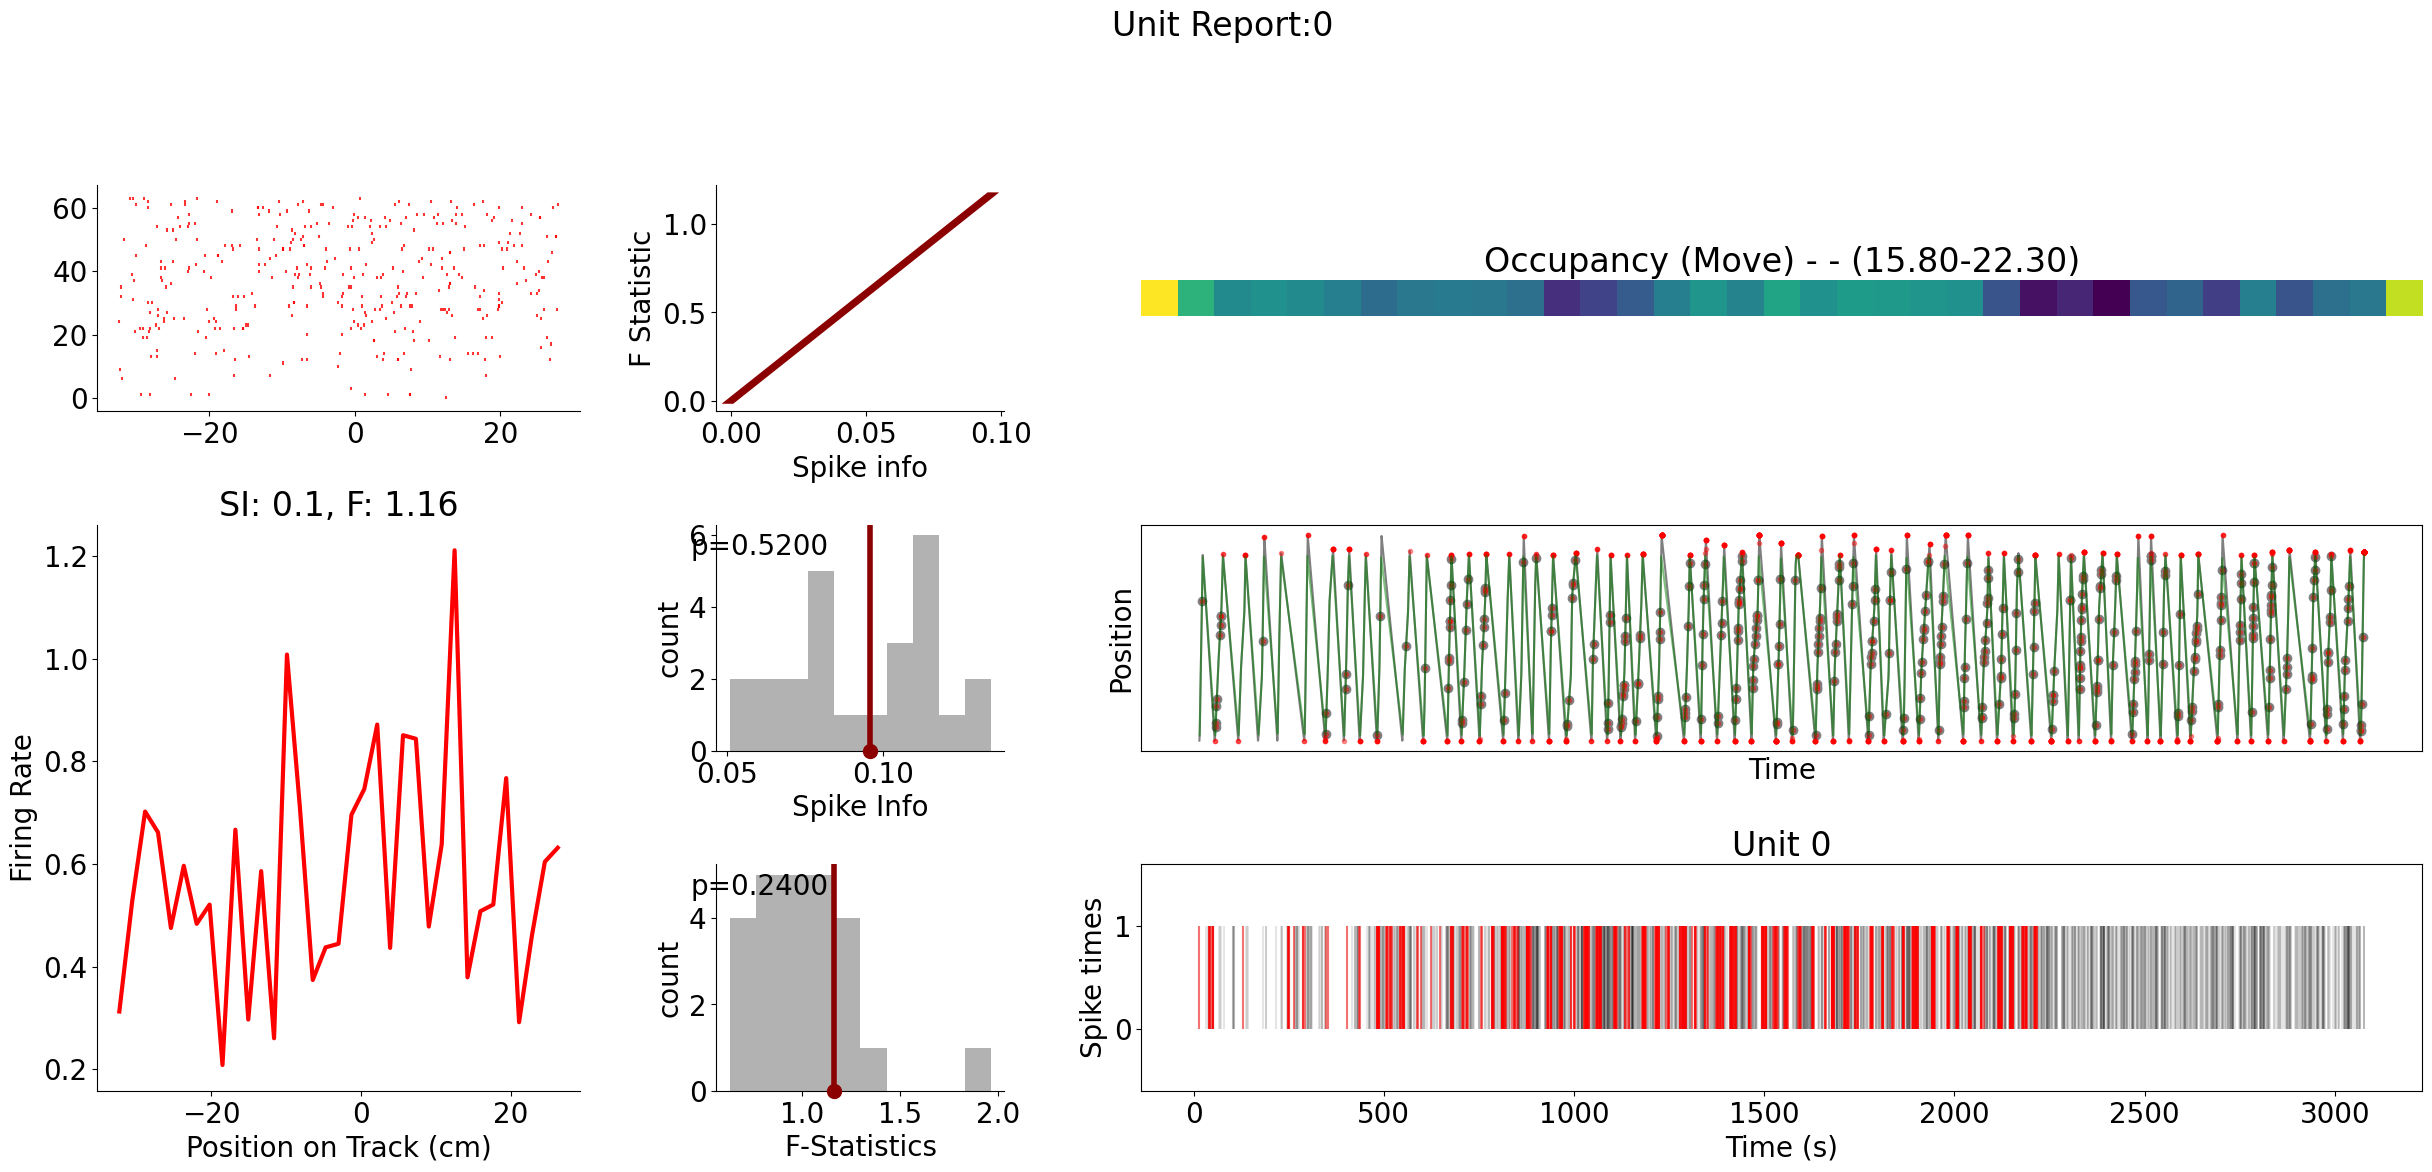

In [110]:
grid = make_grid(6, 6, wspace=.5, hspace=.5, figsize=(30,25),
                                width_ratios=[.7,.5, 1, 1,1,1.5],
                                title= f'Unit Report:{uind}')
plt.rcParams.update({'font.size': 20})
                
# 00: raster across all trials
plot_rasters(spike_pos,ax =get_grid_subplot(grid, slice(0, 1), slice(0,2)), vline=None,color = 'red',alpha =.8,show_axis=True)
drop_spines(['top','right'],get_grid_subplot(grid, slice(0, 1), slice(0,2)))

## 01: place bin firing
ax = get_grid_subplot(grid, slice(1,3), slice(0, 2))
ax.plot(m_bins[:-1],fr, color = 'red', label='Mean Value',linewidth = 3)
#ax.fill_between(m_bins[:-1], fr - fr_std, fr + fr_std, color = 'red', alpha=0.3)
ax.set_xlabel('Position on Track (cm)')
ax.set_ylabel('Firing Rate')
ax.set_title(f"SI: {np.round(spike_info, 2)}, F: {np.round(f_val, 2)}")
drop_spines(['top','right'],get_grid_subplot(grid, slice(1,3), slice(0, 2)))

## 02: Comparison SI vs ANOVA
ax = get_grid_subplot(grid, 0, 2)
ax.arrow(0, 0, spike_info, f_val, head_width=0, head_length=0,linewidth = 4, alpha = 1,fc='darkred', ec='darkred')
ax.set_ylabel('F Statistic')
ax.set_xlabel('Spike info')
drop_spines(['top','right'],get_grid_subplot(grid, 0, 2))
                
## 03: SURROGATES SI 
ax = get_grid_subplot(grid, 1, 2)
plot_surrogates(surrs, data_value=spike_info, p_value=si_p_val,ax = get_grid_subplot(grid, 1, 2),alpha = .6,color = 'grey')
add_vlines(spike_info, ax=get_grid_subplot(grid, 1, 2), color='darkred', linestyle='solid', linewidth=4)
ax.plot(spike_info, 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('Spike Info')
ax.set_ylabel('count')
drop_spines(['top', 'right'],get_grid_subplot(grid, 1, 2))
                
## 04: SURROGATES ANOVA 
ax = get_grid_subplot(grid, 2, 2)
plot_surrogates(surrogates, data_value=f_val, p_value=f_p_val,ax = get_grid_subplot(grid, 2, 2),alpha = .6,color = 'grey')
add_vlines(f_val, ax=None, color='darkred', linestyle='solid', linewidth=4)
ax.plot(f_val, 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('F-Statistics')
ax.set_ylabel('count')
drop_spines(['top', 'right'],get_grid_subplot(grid, 2, 2))

ax = get_grid_subplot(grid, slice(0, 1), slice(3,6))
plot_heatmap(occ_t, title=create_heatmap_title('Occupancy (Move) -',occ_t), ax = get_grid_subplot(grid, slice(0, 1), slice(3,6)))


ax = get_grid_subplot(grid, slice(1, 2), slice(3,6))
plot_position_by_time(ptimes,positions,spikes_t,spikes_p,ax = get_grid_subplot(grid, slice(1, 2), slice(3,6)),color = 'black',alpha = .5)
ax.plot(filt_ptimes, filt_positions,alpha = .5,color = 'green')
ax.scatter(spike_t_all,spike_pos_all, color = 'grey')


ax = get_grid_subplot(grid, slice(2, 3), slice(3,6))
ax.eventplot(spikes, lineoffsets=0.5,color = 'black', alpha = .1)
ax.eventplot(trial_spikes_all, lineoffsets=0.5,color = 'red',alpha = .5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike times')
ax.set_title(f'Unit {uind}')


